# A

In [4]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

In [57]:
dtype = np.float32  # np.float64
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)

df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

nn_type_classification = False

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [58]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
df['strategy'] = strategy(df[target])

df.head()

,EURUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,0.000275,2
2020-11-01 19:30:00,-0.000069,0
2020-11-01 19:40:00,0.000034,2
2020-11-01 19:50:00,0.000026,2


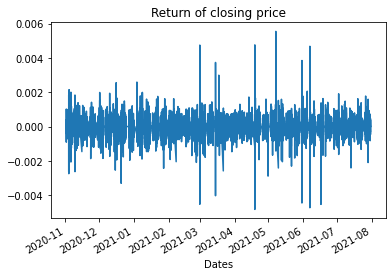

In [59]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [60]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 1)

In [61]:
X_train = sc.inverse_transform(X_train)
X_val = sc.inverse_transform(X_val)
X_test = sc.inverse_transform(X_test)
y_train = sc_target.inverse_transform(y_train)
y_val = sc_target.inverse_transform(y_val)
y_test = sc_target.inverse_transform(y_test)

In [62]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import yule_walker

#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pmd
# see https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
arima = pmd.auto_arima(
    X_train[:, -1, 0],
    d=0,
    start_p=1,
    max_p=20,
    start_q=0,
    max_q=20,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    test='adf',
    trace=True
)
arima

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-303700.090, Time=3.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-303575.312, Time=3.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-303703.016, Time=5.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-303576.522, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-303702.941, Time=12.92 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-303702.825, Time=8.49 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-303696.485, Time=6.82 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-303704.093, Time=1.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-303704.039, Time=0.97 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-303703.882, Time=1.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-303701.173, Time=0.91 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-303697.654, Time=1.72 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 47.597 seconds


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [65]:
mod = sm.tsa.arima.ARIMA(
    X_train[:, -1, 0],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
model_train = mod.fit()

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [66]:
mod_val = sm.tsa.arima.ARIMA(
    X_val[:, -1, 0],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
mod_test = sm.tsa.arima.ARIMA(
    X_test[:, -1, 0],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)

In [67]:
with mod_val.fix_params(dict(zip(model_train.param_names, model_train.params))):
    model_val = mod_val.fit()
with mod_test.fix_params(dict(zip(model_train.param_names, model_train.params))):
    model_test = mod_test.fit()
model_test.predict().reshape([-1,1])
# predict_data(X_train)

array([[ 1.97188747e-06],
       [ 5.27128781e-06],
       [-4.60541418e-06],
       ...,
       [ 4.56039308e-06],
       [ 2.31476619e-06],
       [ 2.14592599e-06]])

In [68]:
def predictions(data_type):
    if data_type == 'train':
        return model_train.predict().reshape([-1,1])
    elif data_type == 'val':
        return model_val.predict().reshape([-1,1])
    elif data_type == 'test':
        return model_test.predict().reshape([-1,1])
    else:
        raise ValueError()

## Econmetric measures

Definition of cumulated returns

In [69]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

## read in data for econmic metric

In [76]:
def econ_metrics(y_pred, X_ret, risk_free=0):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()

    n = 6 * 24 * 250  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (1 / x.shape[0])) ** n - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

In [84]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")
    y_pred = strategy(predictions(tmp_type))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

#     X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
    X_ret = eval(f"X_{tmp_type}")[:, -1, 0] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

    p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret)

train
Accuracy: 0.4873272478580475
Accuracy: 0.4709501266479492
KL_Divergence: 84668.34375
              precision    recall  f1-score   support

         0.0       0.49      0.46      0.47     10870
         1.0       0.00      0.00      0.00       926
         2.0       0.49      0.55      0.52     11285

    accuracy                           0.49     23081
   macro avg       0.33      0.34      0.33     23081
weighted avg       0.47      0.49      0.48     23081



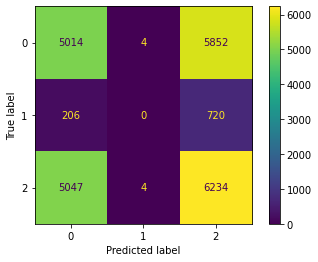

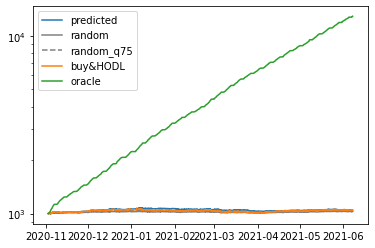

Portfolio return: 0.037668824195861816
Std of returns: 0.0002441240503685549
Sharpe ratio: 154.3019794198608

Return per annum: 0.05937163353583941
Std of returns per annum: 0.04631928184741808
Sharpe ratio per annum: 1.2817908907011453


In [85]:
result_output2('train')

val
Accuracy: 0.5086579918861389
Accuracy: 0.4942280054092407
KL_Divergence: 9090.6044921875
              precision    recall  f1-score   support

         0.0       0.52      0.45      0.49      1370
         1.0       0.00      0.00      0.00        82
         2.0       0.50      0.60      0.54      1320

    accuracy                           0.51      2772
   macro avg       0.34      0.35      0.34      2772
weighted avg       0.50      0.51      0.50      2772



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


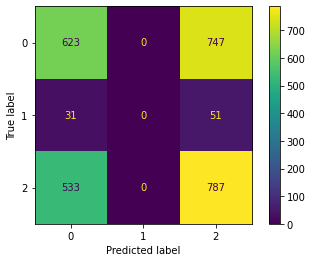

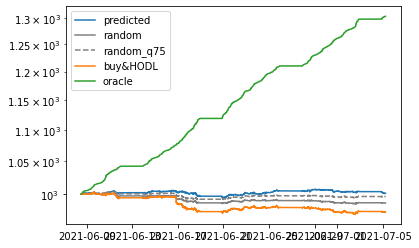

Portfolio return: 0.0012668371200561523
Std of returns: 0.0002181148447562009
Sharpe ratio: 5.808119669581255

Return per annum: 0.016583963491126008
Std of returns per annum: 0.041384382055417696
Sharpe ratio per annum: 0.4007300016928723


In [86]:
result_output2('val')

test
Accuracy: 0.478715717792511
Accuracy: 0.47330448031425476
KL_Divergence: 10654.060546875
              precision    recall  f1-score   support

         0.0       0.47      0.44      0.45      1312
         1.0       0.00      0.00      0.00        75
         2.0       0.49      0.54      0.52      1385

    accuracy                           0.48      2772
   macro avg       0.32      0.33      0.32      2772
weighted avg       0.46      0.48      0.47      2772



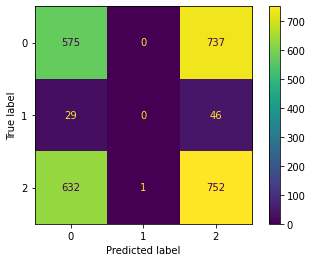

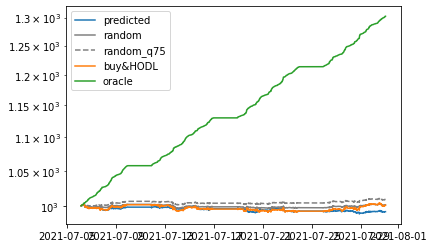

Portfolio return: -0.00817197561264038
Std of returns: 0.0001949756551766768
Sharpe ratio: -41.912799858194404

Return per annum: -0.10111846912420286
Std of returns per annum: 0.036994029518513896
Sharpe ratio per annum: -2.7333726668947347


In [87]:
result_output2('test')